# 🚀 Part 4: To Infinity and Beyond!
We are going to re-run the key cells used to set up our network

In [2]:
# Import relevant libraries
import torch 
import torchvision
from torch import nn 
from torchvision import transforms
from torch.utils import data
import random
import matplotlib.pyplot as plt
import time
from IPython import display
import numpy as np
from helper import helper

random.seed(2021) # We set a seed to ensure our samples will be the same every time we run the code.

In [3]:
# First define the function without running it
def load_data_fashion_mnist(batch_size, n_workers):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../data",
                                                    train=True,
                                                    transform=trans,
                                                    download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data",
                                                   train=False,
                                                   transform=trans,
                                                   download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=n_workers),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=n_workers))

# Then execute the function here
batch_size = 1024  # Set to 256 on your own device
n_workers = 0      # Set to 4 on your own device
train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size, n_workers = n_workers)

In [4]:
# Initialise LeNet Architecture (ans)
net = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size=5, padding=2), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size=5), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
                    nn.Linear(in_features = 16 * 5 * 5, out_features = 120), nn.Sigmoid(),
                    nn.Linear(in_features = 120, out_features = 84), nn.Sigmoid(), 
                    nn.Linear(in_features = 84, out_features = 10))

In [5]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # We will only set the weights from linear and Conv2d layers, since pooling layers do not require this
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights) # nb: this takes in a function as an argument

lr = 0.9 
optimizer = torch.optim.SGD(net.parameters(), lr=lr) 
loss = nn.CrossEntropyLoss() 

## Scaling for Training
### Mini-batches
When we train our model, we often split our dataset into **mini-batches**. Kind of like if you order a huge pizza, you can't eat it all at once, the neural network will struggle to train all the data at once. Let's think of two extremes of mini-batches:
* *Very Small:* suppose you have only one example per mini-batch, you are going to update your network after every single training example. This is very unstable for the training algorithm (it's like trying to survey one person and then using those results to represent the whole Australian population!) it's difficult to know how to update your weights to improve the model with just one example.
* *Very Large:* suppose you have the entire dataset as your mini-batch, you are going to update your network after it evaluates every single example. This will be slow and take up a lot of memory.

Just like with many things in life, there is a trade-off. We have selected a batch-size of `1024` (`256` if you are using your own device) earlier on as we read in the data.

### Epochs
We also train our neural network over our dataset many times. It's like when you first meet someone, you might struggle to recall their face, but after meeting them many more times, the face becomes very familiar to you. Each time we train over our entire dataset is called an **epoch**.  
* Too few epochs and the model does not get a chance to capture the patterns in the data.
* Too many epochs and the model overfits and will not generalise well (we shall see an example later).

The `num_epochs` variable below captures how many epochs we want to train over (set this to `10` if you are using your own device).

**Warning:** The code below will take around 10 minutes to run (depending on the number of epochs). Feel free to grab a coffee while you wait.

![](../images/train_time.png)

([source](https://www.reddit.com/r/ProgrammerHumor/comments/9cu51a/shamelessly_stolen_from_xkcd_credit_where_is_due/))

In [18]:
num_epochs = 5 # Set this to 10 if you are using your own device
epochs = np.arange(num_epochs) + 1

def train_network_scaled(net, num_epochs):
    timer = helper.Timer() 
    # Keep track of accuracy for each epoch
    train_accuracy = np.array([])
    test_accuracy = np.array([])

    print("=== Starting Neural Network Training Now ===")
    for epoch in range(num_epochs):
        metric = helper.Accumulator(3) # define a 3d accumulator
        net.train() # set to train
        for i, (X, y) in enumerate(train_iter): # Loop thru each mini-batch
            timer.start()
            optimizer.zero_grad() # before running the forward/backward pass we need to reset the gradient (otherwise it accumulates)
            y_hat = net(X) # Forward pass on the data to make prediction
            l = loss(y_hat, y) # calculate the loss 
            l.backward() # back propagate the loss
            optimizer.step() # step forward in optimisation
            with torch.no_grad():
                metric.add(l * X.shape[0], helper.accuracy(y_hat, y), X.shape[0]) # mini-batch loss,  # matches, # total examples
            timer.stop()
            train_l = metric[0] / metric[2] # loss per unit 
            train_acc = metric[1] / metric[2] # training accuracy
        test_acc = helper.evaluate_accuracy(net, test_iter)

        train_accuracy = np.append(train_accuracy, train_acc)
        test_accuracy = np.append(test_accuracy, test_acc)
        print("Epoch Number", epoch, "Trained --", f'{timer.sum():.1f} cumulative sec taken ')

    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{timer.sum():.1f} sec taken ')
    
    return (train_accuracy, test_accuracy)

In [19]:
train_accuracy, test_accuracy = train_network_scaled(net = net, num_epochs = 5)

=== Starting Neural Network Training Now ===
Epoch Number 0 Trained -- 4.1 cumulative sec taken 
Epoch Number 1 Trained -- 8.1 cumulative sec taken 
Epoch Number 2 Trained -- 12.2 cumulative sec taken 
Epoch Number 3 Trained -- 16.7 cumulative sec taken 
Epoch Number 4 Trained -- 21.0 cumulative sec taken 
loss 0.522, train acc 0.800, test acc 0.796
21.0 sec taken 


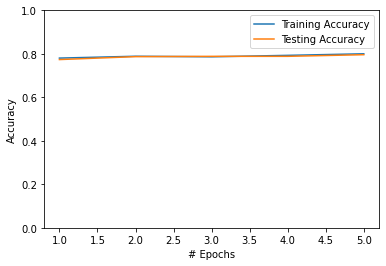

In [20]:
# Let's plot it
plt.plot(epochs, train_accuracy, label = "Training Accuracy")
plt.plot(epochs, test_accuracy, label = "Testing Accuracy")
plt.ylim(0, 1)
plt.xlabel("# Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

With around 5 epochs, you can see that our performance on *both* train and test set have improved considerably from ~10% to around 40-50%. These are still not great, but we have now reached the limits of binder.

If you are using your own machine, I highly encourage you to try 25-30 epochs. We should be able to reach accuracies of almost 80-90% with sufficient training on our LeNet. For instructions on how to do that, refer to the description in the main [github page](https://github.com/bbpi2/cnn-pytorch-tutorial).

---
## <font color='#F89536'> **Discussion:** </font> 
How did that compare with our previous model? How does that compare with random assignment? What can be done to improve the model?

---

## Overfitting
We have talked a lot about how overfitting is bad, but how do we actually tell when a model has overfitted? Recall that:
> Overfitting = performs well on data it's trained on but cannot generalise to unseen data (eg. test)

So if your train accuracy improves but the test accuracy plateaus, then you know you have overfitted! See the example below for a model trained on 500 epochs:

![overfit](../images/overfit.png)

---
## <font color='#F89536'> **Discussion:** </font> 
What is the optimal number of epochs from the graph above?

---

# 📓 Appendix

## <font color='red'> A Lesson on Data Structures: `DataLoader` vs. `DataSet` </font>
PyTorch natively provides two data structures to work with. `DataLoader` and `DataSet`. Here's a bit of comparison:

| `DataSet` | `DataLoader` |
| --- | --- |
| Typical dataset object (like a table) | An iterator object |
| Reads in all the data at once and stores in memory | Reads in data only when the function is called |
| Good for smaller datasets | Good for larger datasets |

When working with big data, it becomes essential to use an iterator like the `DataLoader` object, since we rarely have enough memory to store the 10-20GB of data (not do we need to).